<a href="https://colab.research.google.com/github/Mansi-Awasthi/deep-learning/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

import pandas as pd
import keras
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
#training constants
MAX_SEQ_LEN = 25 
DEFAULT_BATCH_SIZE = 128

In [ ]:
data = pd.read_csv('Sentiment.csv')
train, test = train_test_split(data, random_state = 42, test_size=0.1)
print(train.shape)
print(test.shape)

(12483, 21)
(1388, 21)


In [ ]:
# Mapping of common contractions
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "It's": 'It is', "Can't": 'Can not',
                      }


In [ ]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")
    
    
    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [ ]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
train_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING) for text in test['text'].values]


# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train["text"].values[0])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())


Number of Tokens: 21497
Max Token Index: 21497 

Sample Tweet Before Processing: RT @kvxrdashian: when you leave the Republican Party and become a Democrat. #GOPDebate http://t.co/XrmlHwo1NV
Sample Tweet After Processing: ['RT kvxrdashian when you leave the Republican Party and become a Democrat GOPDebate http t co XrmlHwo1NV'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 2, 2985, 83, 21, 1014, 3, 89, 356, 13, 699, 11, 542, 1, 12, 7, 8, 8669]


In [ ]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['sentiment'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['sentiment'].values)
y_test = to_categorical(y_test) 

In [ ]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['sentiment'].values)
print('Distribution of Classes:', ctr)

y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight('balanced', np.unique(y_train_int), y_train_int)
print(cws)

Distribution of Classes: Counter({'Negative': 7647, 'Neutral': 2834, 'Positive': 2002})
[0.5441 1.4682 2.0784]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=4)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    classes = classes[unique_labels(y_true, y_pred)]
    _cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=classes))
        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()

In [ ]:
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == test['sentiment'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  Negative
Baseline Accuracy Dominant Class 0.6095100864553314
F1 Score: 0.46306910854841044


**Naive Bayes**

Baseline Accuracy Using Naive Bayes:  0.6361671469740634
F1 Score: 0.5223566486665959
              precision    recall  f1-score   support

    Negative       0.63      1.00      0.77       846
     Neutral       0.73      0.06      0.11       308
    Positive       0.87      0.09      0.16       234

    accuracy                           0.64      1388
   macro avg       0.74      0.38      0.35      1388
weighted avg       0.69      0.64      0.52      1388



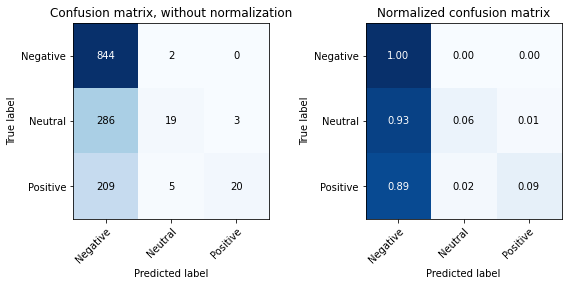

In [ ]:
# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using Naive Bayes: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

_ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_, title='Confusion matrix, without normalization')

**Random Forest**

Baseline Accuracy Using RFC:  0.6765129682997119
F1 Score: 0.6490381558881647
              precision    recall  f1-score   support

    Negative       0.71      0.89      0.79       846
     Neutral       0.55      0.33      0.41       308
    Positive       0.58      0.37      0.45       234

    accuracy                           0.68      1388
   macro avg       0.61      0.53      0.55      1388
weighted avg       0.65      0.68      0.65      1388



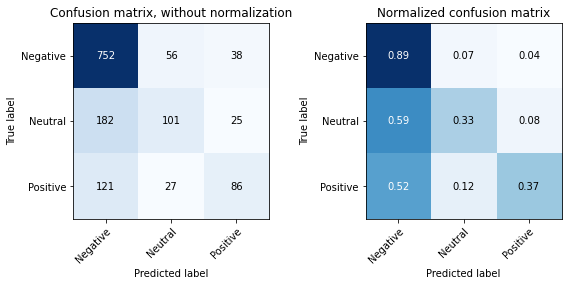

In [ ]:
# Random Forest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=100)), #100 estimators will be the new default in version 0.22
])
text_clf.fit(tokenizer.sequences_to_texts_generator(train_text_vec), y_train.argmax(axis=1))
predictions = text_clf.predict(tokenizer.sequences_to_texts_generator(test_text_vec)) 
print('Baseline Accuracy Using RFC: ', (predictions == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions, average='weighted'))

_ = plot_confusion_matrix(y_test.argmax(axis = 1), predictions, classes=encoder.classes_)

**LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 2,891,779
Trainable params: 2,891,779
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
m1= model.fit(train_text_vec, 
        y_train, 
        validation_data=(test_text_vec, y_test),  
        epochs=25, 
        batch_size=DEFAULT_BATCH_SIZE
)

Epoch 1/25
98/98 [==============================] - 12s 122ms/step - loss: 0.8509 - accuracy: 0.6325 - val_loss: 0.7593 - val_accuracy: 0.6751
Epoch 2/25
98/98 [==============================] - 11s 113ms/step - loss: 0.5934 - accuracy: 0.7574 - val_loss: 0.7522 - val_accuracy: 0.6823
Epoch 3/25
98/98 [==============================] - 11s 113ms/step - loss: 0.3807 - accuracy: 0.8548 - val_loss: 0.9169 - val_accuracy: 0.6585
Epoch 4/25
98/98 [==============================] - 11s 114ms/step - loss: 0.2654 - accuracy: 0.9003 - val_loss: 1.0362 - val_accuracy: 0.6354
Epoch 5/25
98/98 [==============================] - 11s 114ms/step - loss: 0.2109 - accuracy: 0.9177 - val_loss: 1.1739 - val_accuracy: 0.6477
Epoch 6/25
98/98 [==============================] - 12s 119ms/step - loss: 0.1774 - accuracy: 0.9288 - val_loss: 1.3115 - val_accuracy: 0.6729
Epoch 7/25
98/98 [==============================] - 11s 116ms/step - loss: 0.1619 - accuracy: 0.9335 - val_loss: 1.4703 - val_accuracy: 0.6535

44/44 [==============================] - 0s 8ms/step
Validation Loss: 2.411699479538857
Test Accuracy 0.6484149855907781
F1 Score: 0.6466623414666619
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76       846
     Neutral       0.42      0.40      0.41       308
    Positive       0.54      0.55      0.54       234

    accuracy                           0.65      1388
   macro avg       0.57      0.57      0.57      1388
weighted avg       0.65      0.65      0.65      1388



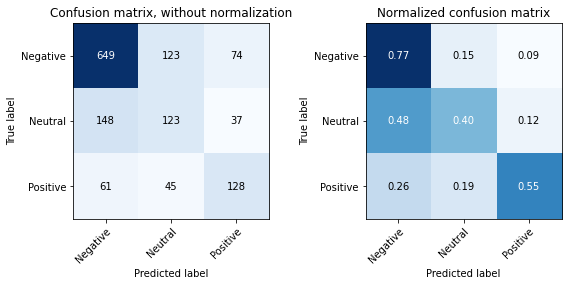

In [ ]:
predictions = model.predict(test_text_vec, verbose=1)
print('Validation Loss:', log_loss(y_test, predictions))
print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
plt.show()   

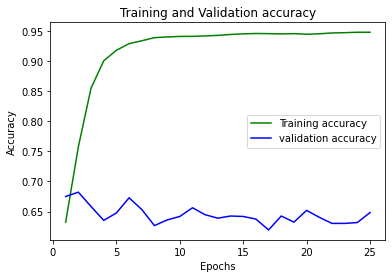

In [ ]:
acc_train=m1.history['accuracy']
acc_val=m1.history['val_accuracy']
epochs=range(1,26)
plt.plot(epochs,acc_train,'g',label='Training accuracy')
plt.plot(epochs,acc_val,'b',label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

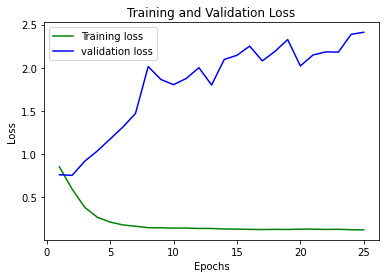

In [ ]:
loss_train=m1.history['loss']
loss_val=m1.history['val_loss']
epochs=range(1,26)
plt.plot(epochs,loss_train,'g',label='Training loss')
plt.plot(epochs,loss_val,'b',label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bidirectional LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 25, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 3,031,555
Trainable params: 3,031,555
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
m2= model.fit(train_text_vec, 
        y_train, 
        validation_data=(test_text_vec, y_test),  
        epochs=25, 
        batch_size=DEFAULT_BATCH_SIZE
)

Epoch 1/25
98/98 [==============================] - 33s 334ms/step - loss: 0.8603 - accuracy: 0.6283 - val_loss: 0.7726 - val_accuracy: 0.6693
Epoch 2/25
98/98 [==============================] - 32s 328ms/step - loss: 0.6453 - accuracy: 0.7313 - val_loss: 0.7324 - val_accuracy: 0.6859
Epoch 3/25
98/98 [==============================] - 32s 330ms/step - loss: 0.4640 - accuracy: 0.8198 - val_loss: 0.8524 - val_accuracy: 0.6715
Epoch 4/25
98/98 [==============================] - 32s 331ms/step - loss: 0.3422 - accuracy: 0.8705 - val_loss: 0.9451 - val_accuracy: 0.6455
Epoch 5/25
98/98 [==============================] - 32s 330ms/step - loss: 0.2632 - accuracy: 0.9003 - val_loss: 1.0416 - val_accuracy: 0.6405
Epoch 6/25
98/98 [==============================] - 32s 330ms/step - loss: 0.2193 - accuracy: 0.9152 - val_loss: 1.1770 - val_accuracy: 0.6592
Epoch 7/25
98/98 [==============================] - 32s 329ms/step - loss: 0.1957 - accuracy: 0.9274 - val_loss: 1.2531 - val_accuracy: 0.6578

44/44 [==============================] - 1s 15ms/step
Validation Loss: 2.068254925502624
Test Accuracy 0.6512968299711815
F1 Score: 0.6480453492116135
              precision    recall  f1-score   support

    Negative       0.75      0.78      0.76       846
     Neutral       0.45      0.42      0.43       308
    Positive       0.52      0.51      0.51       234

    accuracy                           0.65      1388
   macro avg       0.57      0.57      0.57      1388
weighted avg       0.65      0.65      0.65      1388



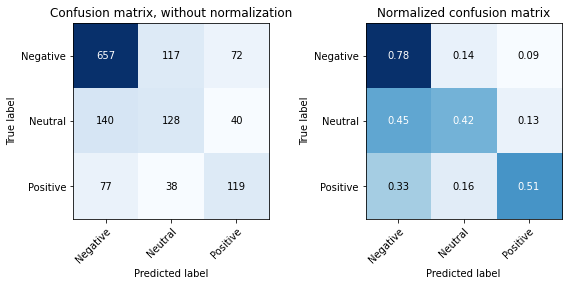

In [ ]:
predictions = model.predict(test_text_vec, verbose=1)
print('Validation Loss:', log_loss(y_test, predictions))
print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
plt.show()

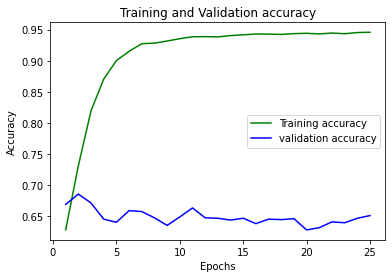

In [ ]:
acc_train=m2.history['accuracy']
acc_val=m2.history['val_accuracy']
epochs=range(1,26)
plt.plot(epochs,acc_train,'g',label='Training accuracy')
plt.plot(epochs,acc_val,'b',label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

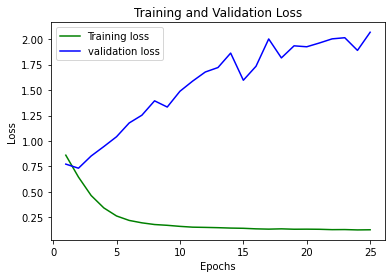

In [ ]:
loss_train=m2.history['loss']
loss_val=m2.history['val_loss']
epochs=range(1,26)
plt.plot(epochs,loss_train,'g',label='Training loss')
plt.plot(epochs,loss_val,'b',label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bidirectional LSTM and CNN**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
model.add(Conv1D(64, 4))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 25, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 25, 256)           263168    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 22, 64)            65600     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 3)                

In [ ]:
m3= model.fit(train_text_vec, 
        y_train, 
        validation_data=(test_text_vec, y_test),  
        epochs=25, 
        batch_size=DEFAULT_BATCH_SIZE
)

Epoch 1/25
98/98 [==============================] - 36s 372ms/step - loss: 0.8587 - accuracy: 0.6280 - val_loss: 0.7583 - val_accuracy: 0.6635
Epoch 2/25
98/98 [==============================] - 36s 371ms/step - loss: 0.6283 - accuracy: 0.7412 - val_loss: 0.7262 - val_accuracy: 0.6924
Epoch 3/25
98/98 [==============================] - 36s 368ms/step - loss: 0.4499 - accuracy: 0.8287 - val_loss: 0.8465 - val_accuracy: 0.6700
Epoch 4/25
98/98 [==============================] - 36s 371ms/step - loss: 0.3363 - accuracy: 0.8749 - val_loss: 0.8991 - val_accuracy: 0.6650
Epoch 5/25
98/98 [==============================] - 36s 369ms/step - loss: 0.2665 - accuracy: 0.9010 - val_loss: 1.0337 - val_accuracy: 0.6535
Epoch 6/25
98/98 [==============================] - 36s 368ms/step - loss: 0.2224 - accuracy: 0.9145 - val_loss: 1.1428 - val_accuracy: 0.6614
Epoch 7/25
98/98 [==============================] - 36s 367ms/step - loss: 0.1955 - accuracy: 0.9253 - val_loss: 1.2065 - val_accuracy: 0.6671

44/44 [==============================] - 1s 18ms/step
Validation Loss: 2.4539475417600203
Test Accuracy 0.654178674351585
F1 Score: 0.6482929347419832
              precision    recall  f1-score   support

    Negative       0.74      0.79      0.77       846
     Neutral       0.45      0.39      0.42       308
    Positive       0.54      0.52      0.53       234

    accuracy                           0.65      1388
   macro avg       0.58      0.57      0.57      1388
weighted avg       0.64      0.65      0.65      1388



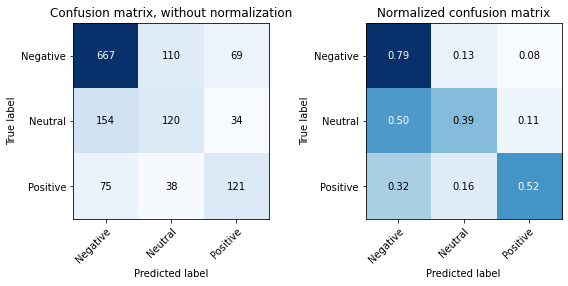

In [ ]:
predictions = model.predict(test_text_vec, verbose=1)
print('Validation Loss:', log_loss(y_test, predictions))
print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
plt.show()

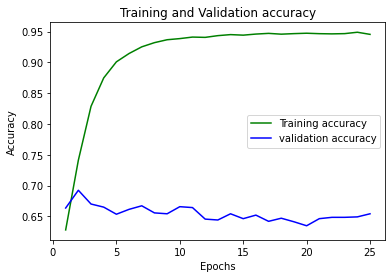

In [ ]:
acc_train=m3.history['accuracy']
acc_val=m3.history['val_accuracy']
epochs=range(1,26)
plt.plot(epochs,acc_train,'g',label='Training accuracy')
plt.plot(epochs,acc_val,'b',label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

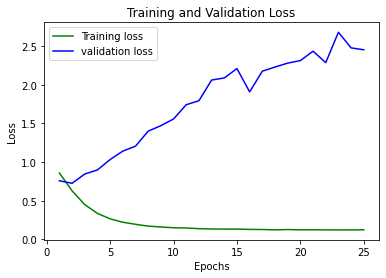

In [ ]:
loss_train=m3.history['loss']
loss_val=m3.history['val_loss']
epochs=range(1,26)
plt.plot(epochs,loss_train,'g',label='Training loss')
plt.plot(epochs,loss_val,'b',label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Convolutional Neural Network**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
model.add(SpatialDropout1D(0.3))
model.add(Conv1D(64, 5))
model.add(Conv1D(64, 3))
model.add(Conv1D(64, 2))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 25, 128)           2751744   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 25, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 64)            41024     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 18, 64)            8256      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

In [ ]:
m4= model.fit(train_text_vec, 
        y_train, 
        validation_data=(test_text_vec, y_test),  
        epochs=25, 
        batch_size=DEFAULT_BATCH_SIZE
)

Epoch 1/25
98/98 [==============================] - 6s 62ms/step - loss: 0.8610 - accuracy: 0.6260 - val_loss: 0.7646 - val_accuracy: 0.6607
Epoch 2/25
98/98 [==============================] - 6s 60ms/step - loss: 0.6394 - accuracy: 0.7354 - val_loss: 0.7331 - val_accuracy: 0.6931
Epoch 3/25
98/98 [==============================] - 6s 60ms/step - loss: 0.4438 - accuracy: 0.8299 - val_loss: 0.8159 - val_accuracy: 0.6744
Epoch 4/25
98/98 [==============================] - 6s 60ms/step - loss: 0.3093 - accuracy: 0.8904 - val_loss: 0.9192 - val_accuracy: 0.6671
Epoch 5/25
98/98 [==============================] - 6s 61ms/step - loss: 0.2371 - accuracy: 0.9166 - val_loss: 1.0078 - val_accuracy: 0.6563
Epoch 6/25
98/98 [==============================] - 6s 60ms/step - loss: 0.1912 - accuracy: 0.9300 - val_loss: 1.1449 - val_accuracy: 0.6571
Epoch 7/25
98/98 [==============================] - 6s 60ms/step - loss: 0.1730 - accuracy: 0.9350 - val_loss: 1.1037 - val_accuracy: 0.6628
Epoch 8/25
98

44/44 [==============================] - 0s 4ms/step
Validation Loss: 2.3406317758412905
Test Accuracy 0.6628242074927954
F1 Score: 0.6534453452043292
              precision    recall  f1-score   support

    Negative       0.76      0.81      0.78       846
     Neutral       0.44      0.34      0.38       308
    Positive       0.53      0.56      0.54       234

    accuracy                           0.66      1388
   macro avg       0.58      0.57      0.57      1388
weighted avg       0.65      0.66      0.65      1388



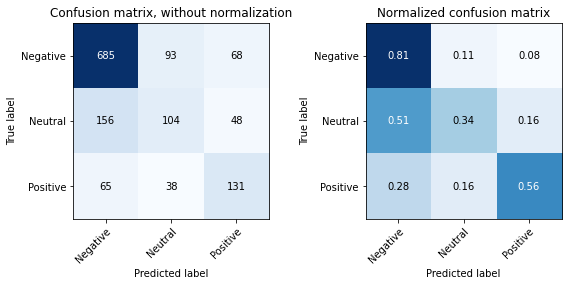

In [ ]:
predictions = model.predict(test_text_vec, verbose=1)
print('Validation Loss:', log_loss(y_test, predictions))
print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
plt.show() 

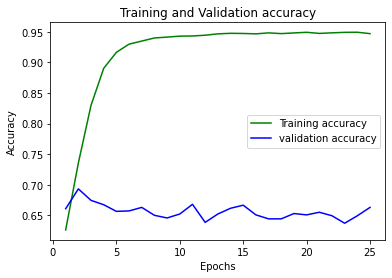

In [ ]:
acc_train=m4.history['accuracy']
acc_val=m4.history['val_accuracy']
epochs=range(1,26)
plt.plot(epochs,acc_train,'g',label='Training accuracy')
plt.plot(epochs,acc_val,'b',label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

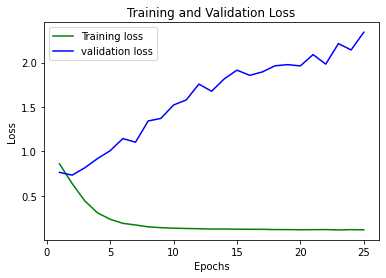

In [ ]:
loss_train=m4.history['loss']
loss_val=m4.history['val_loss']
epochs=range(1,26)
plt.plot(epochs,loss_train,'g',label='Training loss')
plt.plot(epochs,loss_val,'b',label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()